# Project 2.2: English-Italian Machine Translation 

Machine Translation (MT), also known as automated translation, is the process where software translates text from one language to another without human intervention. Currently, machine translation is most effective when a text needs to be understood in another language. The use of deep neural networks has significantly improved the performance and accuracy of machine translation models in recent years. In this project, you are going to develop your machine translation model to translate English text into Italian and vice versa. 

## Data

In [3]:
import os
import tarfile
import requests
import pandas as pd

In [4]:
def download_and_extract(url, extract_to='.'):
    """
    download data specified by 'url', using requests;
    unzip file;
    """
    response = requests.get(url, stream=True)
    file_name = url.split('/')[-1]
    file_path = os.path.join(extract_to, file_name)
    with open(file_path, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
    
    if file_path.endswith("tgz") or file_path.endswith("tar.gz"):
        with tarfile.open(file_path, "r:gz") as tar:
            tar.extractall(path=extract_to)

# data in /data folder
url = "https://www.statmt.org/europarl/v7/it-en.tgz"
extract_to = "./data"
# download_and_extract(url, extract_to)

In [5]:
# extract en and it data
en_file = os.path.join(extract_to, 'europarl-v7.it-en.en')
it_file = os.path.join(extract_to, 'europarl-v7.it-en.it')

# necessary to use 'utf-8'
with open(en_file, 'r', encoding='utf-8') as en_f, open(it_file, 'r', encoding='utf-8') as it_f:
    en_sentences = en_f.readlines()
    it_sentences = it_f.readlines()

In [6]:
data = pd.DataFrame({
    'English': en_sentences,
    'Italian': it_sentences
})
assert len(en_sentences) == len(it_sentences)
print(len(data))

1909115


In [7]:
display(data.head())

,English,Italian
0,Resumption of the session\n,Ripresa della sessione\n
1,I declare resumed the session of the European ...,Dichiaro ripresa la sessione del Parlamento eu...
2,"Although, as you will have seen, the dreaded '...",Come avrete avuto modo di constatare il grande...
3,You have requested a debate on this subject in...,Avete chiesto che si tenesse una discussione s...
4,"In the meantime, I should like to observe a mi...","Nel frattempo è mio desiderio, come del resto ..."


## Task 1: Data exploration

In [8]:
import random
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

In [9]:
# random select 1%
sampled_data = data.sample(frac=0.01, random_state=42)
print(len(sampled_data))
df = sampled_data

19091


In [10]:
#  1. the length differences between two languages 
num_sentences = len(sampled_data)
avg_length_en = df['English'].str.len().mean()
avg_length_it = df['Italian'].str.len().mean()
length_diff = avg_length_en - avg_length_it
print(f"Number of sentences in the sample: {num_sentences}")
print(f"Average length of English sentences: {avg_length_en:.2f}")
print(f"Average length of Italian sentences: {avg_length_it:.2f}")
print(f"Average length difference between English and Italian sentences: {abs(length_diff):.2f}")

Number of sentences in the sample: 19091
Average length of English sentences: 156.96
Average length of Italian sentences: 170.24
Average length difference between English and Italian sentences: 13.29


In [11]:
max_length_en = df['English'].str.len().max()
min_length_en = df['English'].str.len().min()
max_length_it = df['Italian'].str.len().max()
min_length_it = df['Italian'].str.len().min()
print(f"Max length of English sentences: {max_length_en}")
print(f"Min length of English sentences: {min_length_en}")
print(f"Max length of Italian sentences: {max_length_it}")
print(f"Min length of Italian sentences: {min_length_it}")

Max length of English sentences: 754
Min length of English sentences: 1
Max length of Italian sentences: 1320
Min length of Italian sentences: 1


<Axes: title={'center': 'Sentence Length Distribution'}, ylabel='Frequency'>

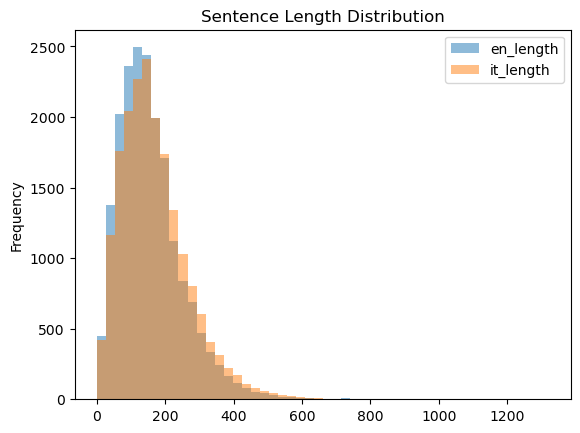

In [12]:
# 2. sentence length distribution
df['en_length'] = df['English'].str.len()
df['it_length'] = df['Italian'].str.len()
df[['en_length', 'it_length']].plot.hist(alpha=0.5, bins=50, title="Sentence Length Distribution")

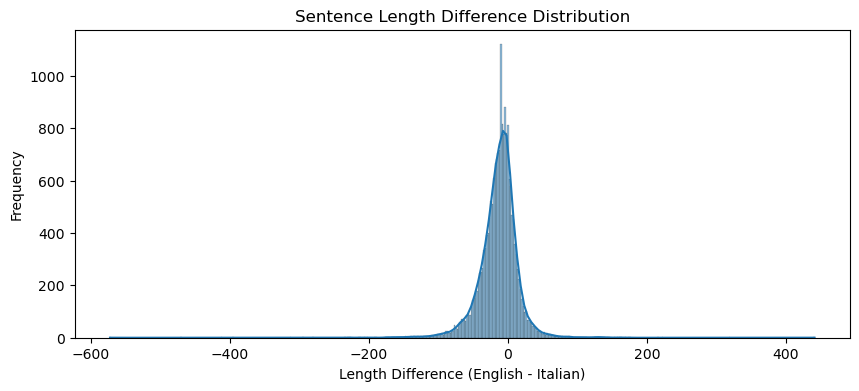

In [13]:
df['length_diff'] = df['en_length'] - df['it_length']
plt.figure(figsize=(10, 4))
sns.histplot(df['length_diff'], kde=True)
plt.title('Sentence Length Difference Distribution')
plt.xlabel('Length Difference (English - Italian)')
plt.ylabel('Frequency')
plt.show()

In [14]:
df['significant_diff'] = df.apply(lambda row: 1 if abs(row['en_length'] - row['it_length']) > 20 else 0, axis=1)
significant_diff_count = df['significant_diff'].sum()
print(f"Number of sentence pairs with significant length difference: {significant_diff_count}")

Number of sentence pairs with significant length difference: 7257


In [15]:
# 3. words highest frequency -> stop words
en_word_freq = Counter(' '.join(df['English']).split())
it_word_freq = Counter(' '.join(df['Italian']).split())
en_common_words = en_word_freq.most_common(20)
it_common_words = it_word_freq.most_common(20)
en_common_words_df = pd.DataFrame(en_common_words, columns=['Word', 'Frequency'])
it_common_words_df = pd.DataFrame(it_common_words, columns=['Word', 'Frequency'])

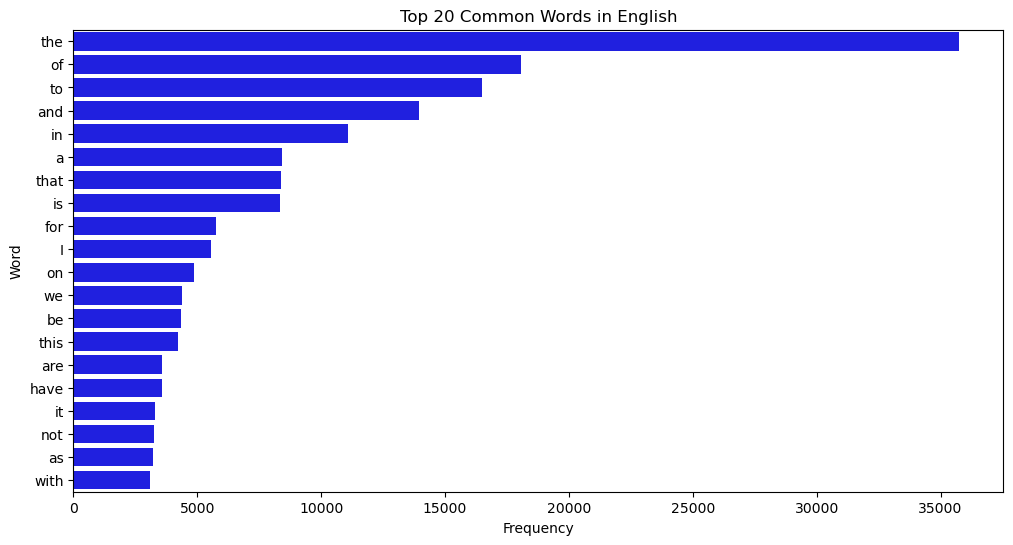

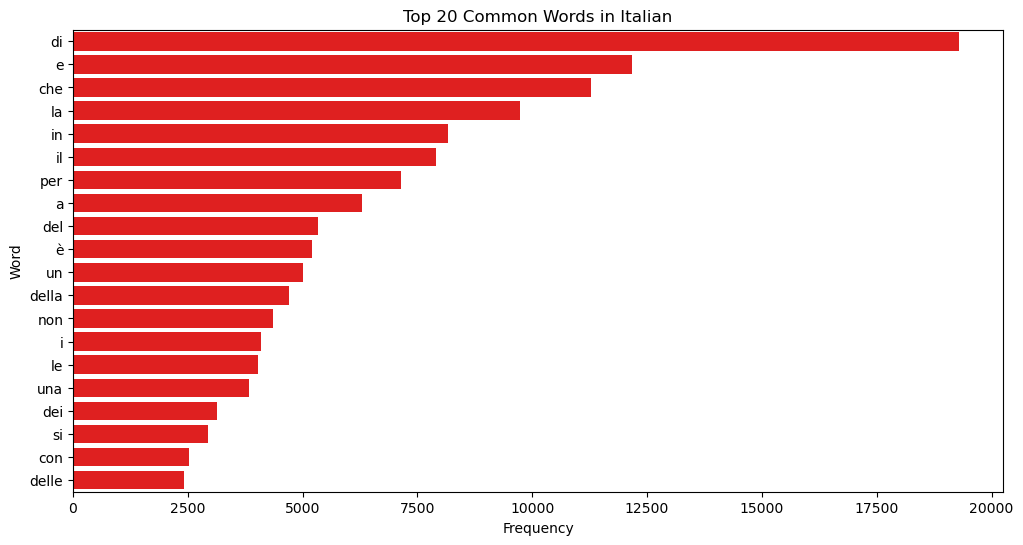

In [16]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=en_common_words_df, color='blue')
plt.title('Top 20 Common Words in English')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=it_common_words_df, color='red')
plt.title('Top 20 Common Words in Italian')
plt.show()

## Task 2: Pre-processing

In [17]:
import string
import re
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from tqdm import tqdm

In [18]:
def preprocess_text(text):
    # Convert all entries to string and remove NaN values
    text = [str(line) for line in text if pd.notna(line)]
    text = [line.lower() for line in text] # lowercase
    text = [line for line in text if not line.startswith('<')] # remove xml label line
    text = [re.sub(r'\s+', ' ', line).strip() for line in text] # remove repeated blanks
    text = [line for line in text if line.strip()] # remove empty lines
    return text

pre_en = pd.DataFrame({'English': preprocess_text(sampled_data['English'])})
pre_it = pd.DataFrame({'Italian': preprocess_text(sampled_data['Italian'])})

In [19]:
pre_samp_data = pd.concat([pre_en, pre_it], axis=1)
display(pre_samp_data.head())
print(len(pre_samp_data))

,English,Italian
0,"if that classes me as a heretic, i hope i do n...",se con queste affermazioni verrò tacciato di e...
1,one thing which we should at least do is stop ...,dovremmo quanto meno smettere di cedere ogni q...
2,"however, as is happening with hedge funds and ...","tuttavia, come sta accadendo con gli hedge fun..."
3,i know that they are making great efforts on t...,so che il governo sta compiendo sforzi ingenti...
4,i call on all those in a position to defend th...,"invito tutti coloro che, in virtù della posizi..."


19060


In [20]:
# don't really know which step create 'float'. here necessary to convert
pre_samp_data['English'] = pre_samp_data['English'].astype(str)
pre_samp_data['Italian'] = pre_samp_data['Italian'].astype(str)
pre_samp_data.dropna(inplace=True)

## Task 3: Neural Machine Translation

In [21]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np

### subtask1: split data

In [22]:
# 20% test data
train_data, test_data = train_test_split(pre_samp_data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

Create tokenizer:

In [34]:
def create_tokenizer(texts, char_l = 0):
    tokenizer = Tokenizer()
    if char_l == 1:
        tokenizer = Tokenizer(char_level=True)
    tokenizer.fit_on_texts(texts)
    return tokenizer

In [24]:
en_tokenizer = create_tokenizer(train_data['English'])
it_tokenizer = create_tokenizer(train_data['Italian'])
display(en_tokenizer)

In [25]:
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines) # text -> numeric
    seq = pad_sequences(seq, maxlen=length, padding='post') # padding to the end
    return seq

max_length_en = max([len(line.split()) for line in train_data['English']])
max_length_it = max([len(line.split()) for line in train_data['Italian']])

X_train = encode_sequences(en_tokenizer, max_length_en, train_data['English'])
X_val = encode_sequences(en_tokenizer, max_length_en, val_data['English'])
X_test = encode_sequences(en_tokenizer, max_length_en, test_data['English'])

y_train = encode_sequences(it_tokenizer, max_length_it, train_data['Italian'])
y_val = encode_sequences(it_tokenizer, max_length_it, val_data['Italian'])
y_test = encode_sequences(it_tokenizer, max_length_it, test_data['Italian'])

### subtask2: RNN based Seq2Seq model, en -> it
* architecture
* embedding models (failed)
* impact: length, features (clarified in the chapter of attention mechanism, leverage better accuracies and loss using that model)

In [26]:
embedding_dim = 150 # vector
units = 32 # LSTM dimension
vocab_size_en = len(en_tokenizer.word_index) + 1 # ensure the idx after padding
vocab_size_it = len(it_tokenizer.word_index) + 1

In [27]:
def s2s_model(vocab_size_en, vocab_size_it, embedding_dim, units):
    encoder_inputs = Input(shape=(None,))
    enc_emb = Embedding(vocab_size_en, embedding_dim, mask_zero=True)(encoder_inputs) # convert into dense vectors of embedding_dim
    encoder_lstm = LSTM(units, return_state=True) # lstm, get hidden state and cell state -> further decoder
    encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
    encoder_states = [state_h, state_c]

    decoder_inputs = Input(shape=(None,))
    dec_emb_layer = Embedding(vocab_size_it, embedding_dim, mask_zero=True)
    dec_emb = dec_emb_layer(decoder_inputs)
    decoder_lstm = LSTM(units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
    decoder_dense = Dense(vocab_size_it, activation='softmax') # softmax for each token
    decoder_outputs = decoder_dense(decoder_outputs)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    return model

In [26]:
model = s2s_model(vocab_size_en, vocab_size_it, embedding_dim, units)

In [43]:
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [44]:
history = model.fit(
    [X_train, y_train[:, :-1]],
    y_train[:, 1:, np.newaxis],
    epochs=10,
    batch_size=16,
    validation_data=([X_val, y_val[:, :-1]], y_val[:, 1:, np.newaxis])
)

Epoch 1/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 629s 728ms/step - accuracy: 0.3091 - loss: 7.9519 - val_accuracy: 0.0070 - val_loss: 6.8699
Epoch 2/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 638s 743ms/step - accuracy: 0.5826 - loss: 6.9623 - val_accuracy: 0.8406 - val_loss: 6.6425
Epoch 3/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 617s 719ms/step - accuracy: 0.8336 - loss: 6.7047 - val_accuracy: 0.8431 - val_loss: 6.4610
Epoch 4/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 727s 847ms/step - accuracy: 0.8357 - loss: 6.5083 - val_accuracy: 0.8461 - val_loss: 6.3086
Epoch 5/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 918s 1s/step - accuracy: 0.8396 - loss: 6.3109 - val_accuracy: 0.8473 - val_loss: 6.1764
Epoch 6/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 892s 1s/step - accuracy: 0.8429 - loss: 6.1452 - val_accuracy: 0.8478 - val_loss: 6.0740
Epoch 7/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 884s 1s/step - accuracy: 0.8430 - loss: 6.0189 - val_accuracy: 0.8482 - val_loss: 5.9880
Epoch 8/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 891s 1s/step - accuracy: 0.8439 - loss: 5.880

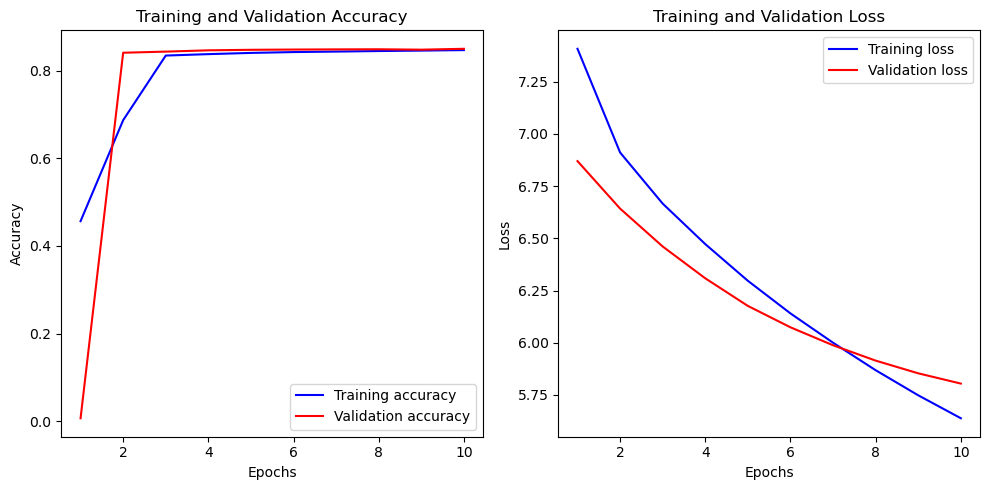

In [55]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [45]:
loss, accuracy = model.evaluate([X_test, y_test[:, :-1]], y_test[:, 1:, np.newaxis])
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

120/120 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.8498 - loss: 5.8165
Test Loss: 5.809578895568848, Test Accuracy: 0.849186360836029


### subtask3: it -> en
* compare results

In [58]:
y_train = encode_sequences(en_tokenizer, max_length_en, train_data['English'])
y_val = encode_sequences(en_tokenizer, max_length_en, val_data['English'])
y_test = encode_sequences(en_tokenizer, max_length_en, test_data['English'])

X_train = encode_sequences(it_tokenizer, max_length_it, train_data['Italian'])
X_val = encode_sequences(it_tokenizer, max_length_it, val_data['Italian'])
X_test = encode_sequences(it_tokenizer, max_length_it, test_data['Italian'])

In [67]:
model_rev = s2s_model(vocab_size_it, vocab_size_en, embedding_dim, units)
model_rev.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_rev = model_rev.fit(
    [X_train, y_train[:, :-1]],
    y_train[:, 1:, np.newaxis],
    epochs=8,
    batch_size=16,
    validation_data=([X_val, y_val[:, :-1]], y_val[:, 1:, np.newaxis])
)

Epoch 1/8
858/858 ━━━━━━━━━━━━━━━━━━━━ 473s 547ms/step - accuracy: 0.0132 - loss: 7.2946 - val_accuracy: 0.0146 - val_loss: 6.2721
Epoch 2/8
858/858 ━━━━━━━━━━━━━━━━━━━━ 463s 540ms/step - accuracy: 0.0157 - loss: 6.3024 - val_accuracy: 0.0247 - val_loss: 6.0497
Epoch 3/8
858/858 ━━━━━━━━━━━━━━━━━━━━ 465s 542ms/step - accuracy: 0.4775 - loss: 6.0528 - val_accuracy: 0.8350 - val_loss: 5.8201
Epoch 4/8
858/858 ━━━━━━━━━━━━━━━━━━━━ 469s 547ms/step - accuracy: 0.7177 - loss: 5.8104 - val_accuracy: 0.0632 - val_loss: 5.6494
Epoch 5/8
858/858 ━━━━━━━━━━━━━━━━━━━━ 466s 543ms/step - accuracy: 0.2520 - loss: 5.6123 - val_accuracy: 0.8366 - val_loss: 5.5240
Epoch 6/8
858/858 ━━━━━━━━━━━━━━━━━━━━ 463s 539ms/step - accuracy: 0.8306 - loss: 5.4523 - val_accuracy: 0.8410 - val_loss: 5.4414
Epoch 7/8
858/858 ━━━━━━━━━━━━━━━━━━━━ 598s 697ms/step - accuracy: 0.8389 - loss: 5.3400 - val_accuracy: 0.8395 - val_loss: 5.3904
Epoch 8/8
858/858 ━━━━━━━━━━━━━━━━━━━━ 591s 688ms/step - accuracy: 0.8421 - loss: 5

In [68]:
loss, accuracy = model_rev.evaluate([X_test, y_test[:, :-1]], y_test[:, 1:, np.newaxis])
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

120/120 ━━━━━━━━━━━━━━━━━━━━ 79s 645ms/step - accuracy: 0.8385 - loss: 5.3651
Test Loss: 5.355792045593262, Test Accuracy: 0.8393846750259399


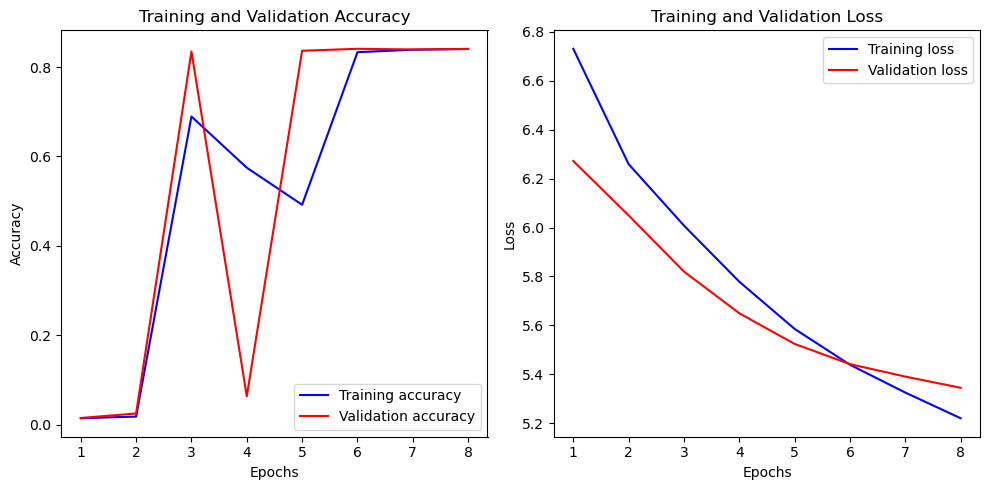

In [69]:
plot_training_history(history_rev)

### subtask4: character-based model

In [40]:
en_tokenizer_char = create_tokenizer(train_data['English'], 1)
it_tokenizer_char = create_tokenizer(train_data['Italian'], 1)

max_length_en_char = max([len(seq) for seq in train_data['English']])
max_length_it_char = max([len(seq) for seq in train_data['Italian']])

In [41]:
X_train_char = encode_sequences(en_tokenizer_char, max_length_en_char, train_data['English'])
X_val_char = encode_sequences(en_tokenizer_char, max_length_en_char, val_data['English'])
X_test_char = encode_sequences(en_tokenizer_char, max_length_en_char, test_data['English'])

y_train_char = encode_sequences(it_tokenizer_char, max_length_it_char, train_data['Italian'])
y_val_char = encode_sequences(it_tokenizer_char, max_length_it_char, val_data['Italian'])
y_test_char = encode_sequences(it_tokenizer_char, max_length_it_char, test_data['Italian'])

In [42]:
embedding_dim = 300 # vector: 64 words

In [ ]:
vocab_size_en_char = len(en_tokenizer_char.word_index) + 1
vocab_size_it_char = len(it_tokenizer_char.word_index) + 1
model_char = s2s_model(vocab_size_en_char, vocab_size_it_char, embedding_dim, units)

model_char.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_char = model_char.fit(
    [X_train_char, y_train_char[:, :-1]],
    y_train_char[:, 1:, np.newaxis],
    epochs=8,
    batch_size=16,
    validation_data=([X_val_char, y_val_char[:, :-1]], y_val_char[:, 1:, np.newaxis])
)

Epoch 1/8
858/858 ━━━━━━━━━━━━━━━━━━━━ 893s 1s/step - accuracy: 0.0385 - loss: 2.8582 - val_accuracy: 0.0579 - val_loss: 2.1554
Epoch 2/8
857/858 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - accuracy: 0.0615 - loss: 2.0893

## Task 4: Neural Machine Translation with Attention

In [37]:
from tensorflow.keras.layers import Dot, Activation, Concatenate
from tensorflow.keras.models import load_model
import pickle

In [46]:
def attention_model(vocab_size_en, vocab_size_it, embedding_dim, units):
    """
    extended version of the encoder-decoder model used above
    """
    encoder_inputs = Input(shape=(None,))
    enc_emb = Embedding(vocab_size_en, embedding_dim, mask_zero=True)(encoder_inputs)
    encoder_lstm = LSTM(units, return_sequences=True, return_state=True)
    encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
    encoder_states = [state_h, state_c]

    decoder_inputs = Input(shape=(None,))
    dec_emb_layer = Embedding(vocab_size_it, embedding_dim, mask_zero=True)
    dec_emb = dec_emb_layer(decoder_inputs)
    decoder_lstm = LSTM(units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

    # implement attention
    # batch * en time step * de time step
    attention = Dot(axes=[2, 2])([decoder_outputs, encoder_outputs])
    attention = Activation('softmax', name='attention_softmax')(attention) # weights -> 1, name the layer for visualization
    context = Dot(axes=[2, 1])([attention, encoder_outputs]) # context vector

    decoder_combined_context = Concatenate(axis=-1)([context, decoder_outputs])

    decoder_dense = Dense(vocab_size_it, activation='softmax') # combined inputs -> fully connected layer
    decoder_outputs = decoder_dense(decoder_combined_context)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    return model

In [47]:
model_att = build_attention_model(vocab_size_en, vocab_size_it, embedding_dim, units)
model_att.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [48]:
history_att = model_att.fit(
    [X_train, y_train[:, :-1]],
    y_train[:, 1:, np.newaxis],
    epochs=8,
    batch_size=16,
    validation_data=([X_val, y_val[:, :-1]], y_val[:, 1:, np.newaxis])
)

Epoch 1/8
858/858 ━━━━━━━━━━━━━━━━━━━━ 621s 719ms/step - accuracy: 0.8232 - loss: 3.1267 - val_accuracy: 0.8398 - val_loss: 1.1567
Epoch 2/8
858/858 ━━━━━━━━━━━━━━━━━━━━ 630s 734ms/step - accuracy: 0.8330 - loss: 1.2242 - val_accuracy: 0.8456 - val_loss: 1.0892
Epoch 3/8
858/858 ━━━━━━━━━━━━━━━━━━━━ 626s 730ms/step - accuracy: 0.8375 - loss: 1.1610 - val_accuracy: 0.8483 - val_loss: 1.0423
Epoch 4/8
858/858 ━━━━━━━━━━━━━━━━━━━━ 640s 745ms/step - accuracy: 0.8428 - loss: 1.0953 - val_accuracy: 0.8498 - val_loss: 1.0138
Epoch 5/8
858/858 ━━━━━━━━━━━━━━━━━━━━ 642s 748ms/step - accuracy: 0.8464 - loss: 1.0479 - val_accuracy: 0.8505 - val_loss: 0.9950
Epoch 6/8
858/858 ━━━━━━━━━━━━━━━━━━━━ 623s 726ms/step - accuracy: 0.8477 - loss: 1.0198 - val_accuracy: 0.8516 - val_loss: 0.9821
Epoch 7/8
858/858 ━━━━━━━━━━━━━━━━━━━━ 636s 741ms/step - accuracy: 0.8495 - loss: 0.9937 - val_accuracy: 0.8525 - val_loss: 0.9727
Epoch 8/8
858/858 ━━━━━━━━━━━━━━━━━━━━ 649s 756ms/step - accuracy: 0.8500 - loss: 0

In [50]:
loss_att, accuracy_att = model_att.evaluate([X_test, y_test[:, :-1]], y_test[:, 1:, np.newaxis])
print(f'Attention Model Test Loss: {loss_att}, Test Accuracy: {accuracy_att}')

Attention Model Test Loss: 0.9729918241500854, Test Accuracy: 0.8522113561630249


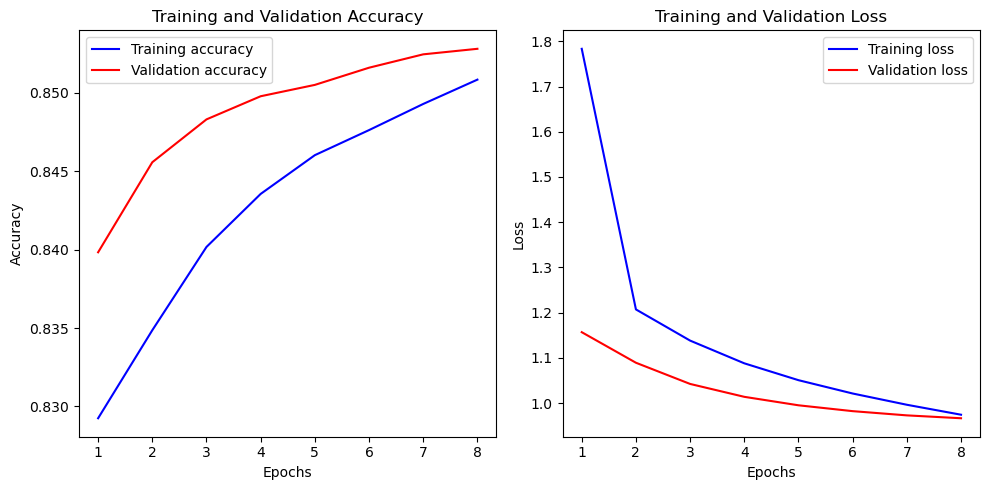

In [32]:
plot_training_history(history_att)

### subtask1: visualize attention weights

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step


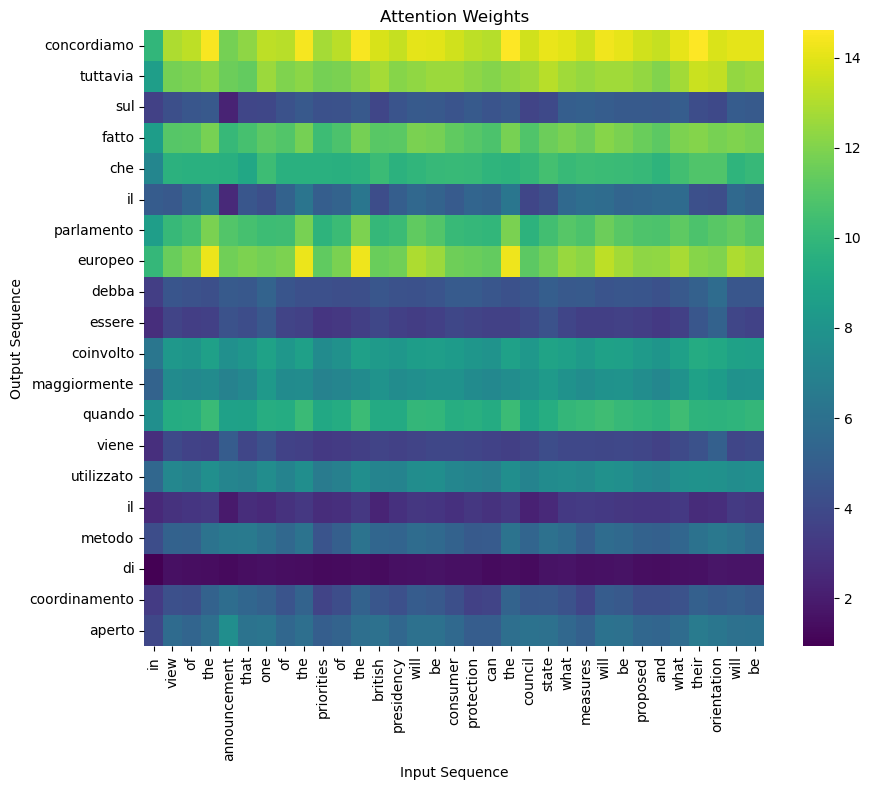

In [54]:
def plot_attention_weights(attention_model, input_seq, output_seq, tokenizer_en, tokenizer_it):
    # create new model
    attention_layer_model = Model(inputs=attention_model.input, outputs=attention_model.get_layer('attention_softmax').output) 
    attention_weights = attention_layer_model.predict([input_seq, output_seq])

    # first one in batch
    attention_weights = attention_weights[0]
    # convert to words
    input_words = [tokenizer_en.index_word[i] for i in input_seq[0] if i != 0]
    output_words = [tokenizer_it.index_word[i] for i in output_seq[0] if i != 0]

    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_weights[:len(output_words), :len(input_words)], xticklabels=input_words, yticklabels=output_words, cmap='viridis')
    plt.xlabel('Input Sequence')
    plt.ylabel('Output Sequence')
    plt.title('Attention Weights')
    plt.show()

sample_input_seq = X_test[:1] # 1 sample
sample_output_seq = y_test[:1]
plot_attention_weights(model_att, sample_input_seq, sample_output_seq, en_tokenizer, it_tokenizer)

In [37]:
# recover the model
# model_att.save('model_att.keras')
# with open('history_att.pkl', 'wb') as file:
#     pickle.dump(history_att.history, file)

model_att = load_model('model_att.keras')
with open('history_att.pkl', 'rb') as file:
    history_att = pickle.load(file)
print(history_att)

{'accuracy': [0.8292471766471863, 0.834863543510437, 0.8401759266853333, 0.8435588479042053, 0.8460315465927124, 0.8476306796073914, 0.8492982983589172, 0.8508498668670654], 'loss': [1.78345787525177, 1.2070684432983398, 1.1381161212921143, 1.0878663063049316, 1.050573468208313, 1.0211113691329956, 0.9962232112884521, 0.9741958975791931], 'val_accuracy': [0.8398350477218628, 0.845580518245697, 0.8483138084411621, 0.8497900366783142, 0.8505147099494934, 0.8516106605529785, 0.8524636626243591, 0.852816641330719], 'val_loss': [1.1567437648773193, 1.0891534090042114, 1.0422734022140503, 1.013769507408142, 0.9950397610664368, 0.9820918440818787, 0.9727495312690735, 0.9663861393928528]}


### subtask2: interpret the model results

In [49]:
def evaluate_length_impact(model, X_test, y_test, max_length):
    lengths = []
    losses = []
    accuracies = []
    for i in range(1, max_length + 1):
        indices = [j for j, seq in enumerate(X_test) if np.count_nonzero(seq) == i]
        if not indices:
            continue
        X_test_subset = X_test[indices] # cut
        y_test_subset = y_test[indices]

        loss, accuracy = model.evaluate([X_test_subset, y_test_subset[:, :-1]], y_test_subset[:, 1:, np.newaxis], verbose=0) # reuse
        lengths.append(i)
        losses.append(loss)
        accuracies.append(accuracy)

    return lengths, losses, accuracies

max_length = max_length_en 
lengths, losses, accuracies = evaluate_length_impact(model_att, X_test, y_test, max_length)

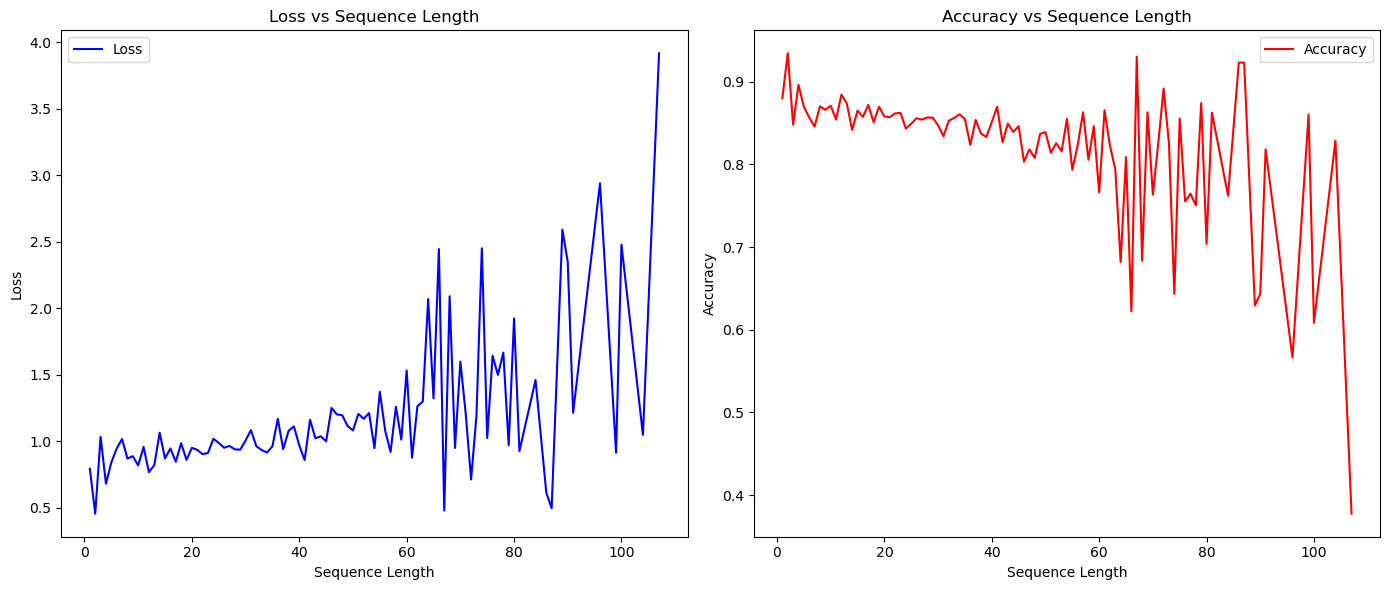

In [51]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(lengths, losses, 'b', label='Loss')
plt.xlabel('Sequence Length')
plt.ylabel('Loss')
plt.title('Loss vs Sequence Length')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lengths, accuracies, 'r', label='Accuracy')
plt.xlabel('Sequence Length')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Sequence Length')
plt.legend()

plt.tight_layout()
plt.show()